In [1]:
#import xarray as xr

import numpy as np
import pandas as pd
from pathlib import Path

import os, sys
import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as tkr
#import seaborn as sns
#sns.set_style('ticks')

from scipy import stats
from scipy.stats import percentileofscore

from datetime import datetime, timedelta
from vtools.functions.filter import cosine_lanczos
from vtools.data.vtime import days, hours, minutes

# from sklearn.model_selection import train_test_split
# from sklearn.model_selection import TimeSeriesSplit
# from sklearn.linear_model import LinearRegression
# from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
# from sklearn.preprocessing import StandardScaler,MinMaxScaler
# #from sklearn.datasets import fetch_california_housing

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Plot Salinity time series at a few stations with the mean sea level pressure anomaly to see if I can identify s subtidal pumping event

## pull salinity data from screened directory from DWR /global/scratch/users/jennaisrael/validation_data/screened

How does the schimpy utility batch_metrics compile these files? https://github.com/CADWRDeltaModeling/schimpy/blob/master/schimpy/batch_metrics.py?
I think I want the function find_obs_file

In [2]:
#function comes from schimpy metricsplot.py script https://github.com/CADWRDeltaModeling/schimpy/blob/master/schimpy/metricsplot.py
def filter_timeseries(tss, cutoff_period=hours(40)):
    """ Filter time series

        Parameters
        ----------

        Returns
        -------
        list of vtools.data.timeseries.TimeSeries
            filtered time series
    """

    filtered = []
    ts=tss #try removing the loop for now
    if ts is None:
        filtered.append(None)
    else:
        #print(ts)
        ts_filtered = cosine_lanczos(ts, cutoff_period=cutoff_period)
        ts_filtered.filtered = 'cosine_lanczos'
        #ts_filtered.unit = ts.unit
        #filtered.append(ts_filtered)
    # for ts in tss:
    #     if ts is None:
    #         filtered.append(None)
    #     else:
    #         print(ts)
    #         ts_filtered = cosine_lanczos(ts, cutoff_period=cutoff_period)
    #         ts_filtered.filtered = 'cosine_lanczos'
    #         ts_filtered.unit = ts.unit
    #         filtered.append(ts_filtered)
    return ts_filtered

In [3]:
#also from metricsplot.py
def fill_gaps(ts, max_gap_to_fill=None):

    if max_gap_to_fill is None or max_gap_to_fill == hours(0):
        return ts
    try:
        limit = int(max_gap_to_fill/ts.index.freq)
    except:
        raise ValueError("could not divide max_gap_to_fill by freq: {}".format(ts.index.freq))
    if limit == 0:
        raise ValueError("max_gap_to_fill must be longer than time step")
    #unit = ts.value.unit

    ts = ts.interpolate(method='time',limit=limit)
    #ts.value.unit = unit
    return ts

# Plot tidally filtered Emmaton and Franks Tract salinity with tidally filtered Golden Gate elevation

In [4]:
emm_ts=pd.read_csv("/global/scratch/users/jennaisrael/validation_data/salinity_time_series/emm_upper_salt_obs.csv",parse_dates=["datetime"]).set_index("datetime").asfreq('15min')
emm_ts

,value
datetime,
1999-03-27 10:15:00,0.078923
1999-03-27 10:30:00,0.084195
1999-03-27 10:45:00,0.085633
1999-03-27 11:00:00,0.083715
1999-03-27 11:15:00,0.086113
...,...
2024-05-13 22:00:00,0.062166
2024-05-13 22:15:00,0.062644
2024-05-13 22:30:00,0.062644


In [5]:
emm_ts.index[0]

Timestamp('1999-03-27 10:15:00', freq='15T')

In [6]:
emm_ts.index.freq

<15 * Minutes>

In [7]:
emm_filt=filter_timeseries(emm_ts)

In [8]:
jer_ts=pd.read_csv("/global/scratch/users/jennaisrael/validation_data/salinity_time_series/jer_default_salt_obs.csv",parse_dates=["datetime"]).set_index("datetime").asfreq('15min')
hro_ts=pd.read_csv("/global/scratch/users/jennaisrael/validation_data/salinity_time_series/hro_default_salt_obs.csv",parse_dates=["datetime"]).set_index("datetime").asfreq('15min')


In [9]:
jer_ts

,value
datetime,
1999-03-26 07:15:00,0.077486
1999-03-26 07:30:00,0.077486
1999-03-26 07:45:00,0.077965
1999-03-26 08:00:00,0.079402
1999-03-26 08:15:00,0.079881
...,...
2024-05-13 22:00:00,0.090910
2024-05-13 22:15:00,0.090430
2024-05-13 22:30:00,0.090910


In [10]:
#set the unit of salinity
jer_ts.value.unit='PSU'

In [11]:
jer_filt=filter_timeseries(jer_ts)
hro_filt=filter_timeseries(hro_ts)

<AxesSubplot:xlabel='datetime'>

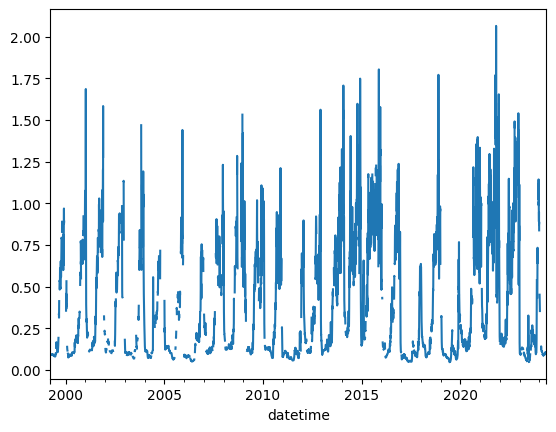

In [12]:
jer_filt.value.plot()

In [13]:
jer_filt_fill=fill_gaps(jer_filt, max_gap_to_fill='96 h')

<AxesSubplot:xlabel='datetime'>

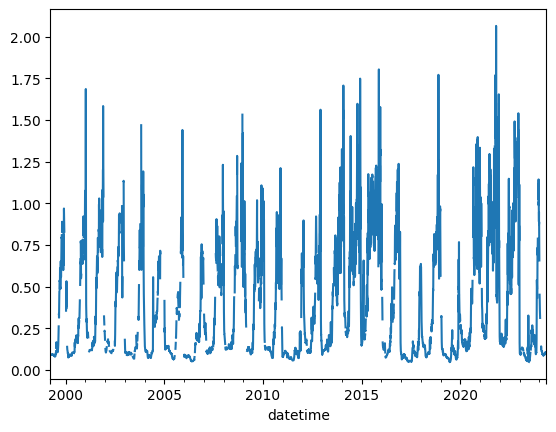

In [14]:
jer_filt_fill.value.plot()

#try gapfilling first and then filtering- looks much better

<AxesSubplot:xlabel='datetime'>

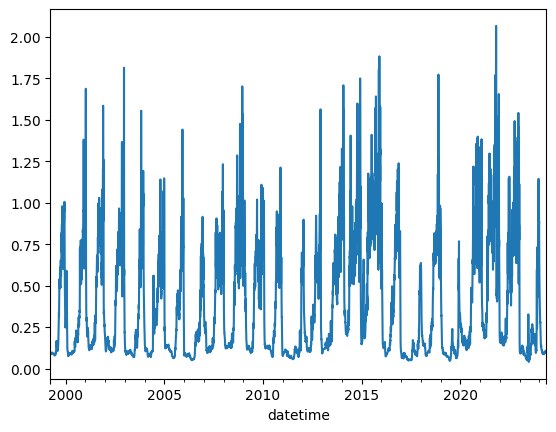

In [15]:
jer_fill=fill_gaps(jer_ts, max_gap_to_fill='96 h')
jer_fill_filt=filter_timeseries(jer_fill)
jer_fill_filt.value.plot()

In [18]:
jer_fill_filt

,value
datetime,
1999-03-26 07:15:00,NaN
1999-03-26 07:30:00,NaN
1999-03-26 07:45:00,NaN
1999-03-26 08:00:00,NaN
1999-03-26 08:15:00,NaN
...,...
2024-05-13 22:00:00,NaN
2024-05-13 22:15:00,NaN
2024-05-13 22:30:00,NaN


In [17]:
jer_fill_filt.to_csv("jersey_pt_gap_filled_filtered.csv")

<AxesSubplot:xlabel='datetime'>

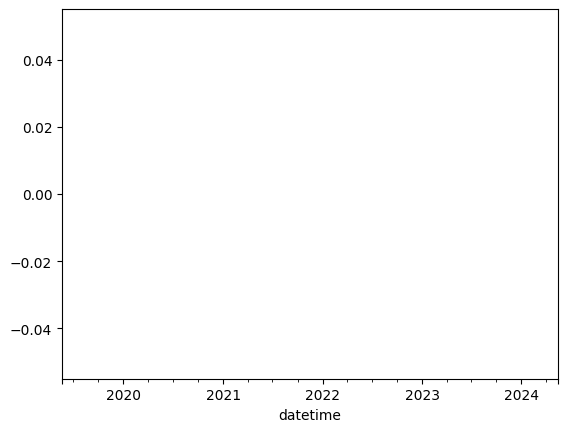

In [10]:
hro_filt.value.plot()

In [11]:
## Load the era5 at point reyes
df_pr=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/sl_regression/point_reyes.regression.data.hourly.1996.2020.csv",parse_dates=['time']).set_index(['time'])
df_pr

,u10_stress_a,v10_stress_a,msl_a,sst_a,PDO_a,EN3.4_a,Residual
time,,,,,,,
1995-12-31 16:00:00,14.930421,-24.119721,829.992691,1.281503,0.836933,-1.306148,-0.120008
1995-12-31 17:00:00,17.991777,-27.508239,863.427660,1.281503,0.836933,-1.306148,-0.151616
1995-12-31 18:00:00,21.935901,-32.693511,814.427629,1.281502,0.836933,-1.306148,-0.139688
1995-12-31 19:00:00,29.985567,-46.579936,820.677598,1.281502,0.836933,-1.306148,-0.160621
1995-12-31 20:00:00,37.616582,-53.565272,781.427567,1.281501,0.836933,-1.306148,-0.136845
...,...,...,...,...,...,...,...
2021-10-01 19:00:00,-25.725292,23.005474,-46.447343,1.863969,-2.707063,-1.352207,-0.019173
2021-10-01 20:00:00,-20.123032,21.398286,-69.637374,1.863968,-2.707063,-1.352207,-0.013346
2021-10-01 21:00:00,-8.551838,14.932600,-93.887405,1.863968,-2.707063,-1.352207,-0.008039


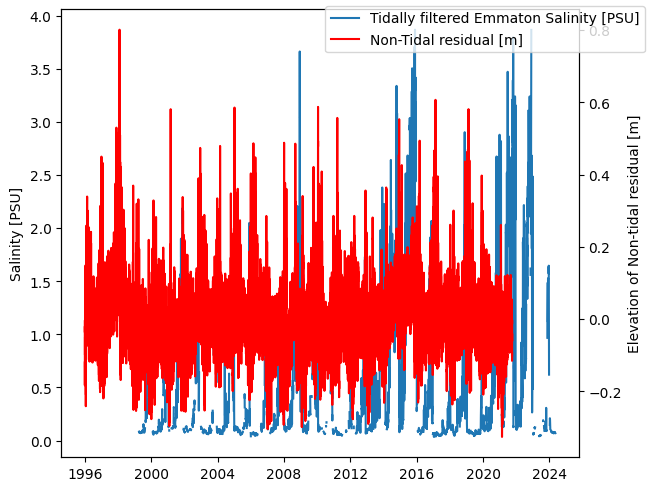

In [12]:
#plot emmaton salinity on one axis and residual on another 
fig, ax = plt.subplots(layout="constrained",sharex=True)

ax.plot(emm_filt.value, label="Tidally filtered Emmaton Salinity [PSU]")
ax.set_ylabel("Salinity [PSU]")
ax2=ax.twinx()
ax2.plot(df_pr.Residual, label="Non-Tidal residual [m]", color='r')
ax2.set_ylabel("Elevation of Non-tidal residual [m]")
fig.legend()

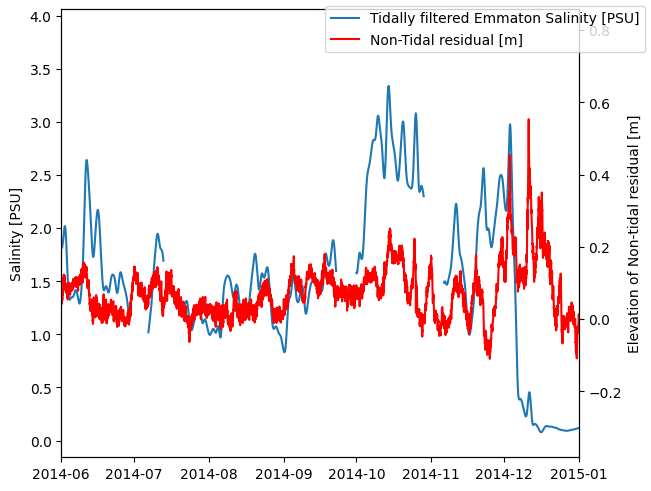

In [13]:
#plot emmaton salinity on one axis and residual on another 
fig, ax = plt.subplots(layout="constrained",sharex=True)

ax.plot(emm_filt.value, label="Tidally filtered Emmaton Salinity [PSU]")
ax.set_ylabel("Salinity [PSU]")
ax2=ax.twinx()
ax2.plot(df_pr.Residual, label="Non-Tidal residual [m]", color='r')
ax2.set_ylabel("Elevation of Non-tidal residual [m]")
fig.legend()
ax.set_xlim(datetime(2014,6,1),datetime(2015,1,1))
plt.show()

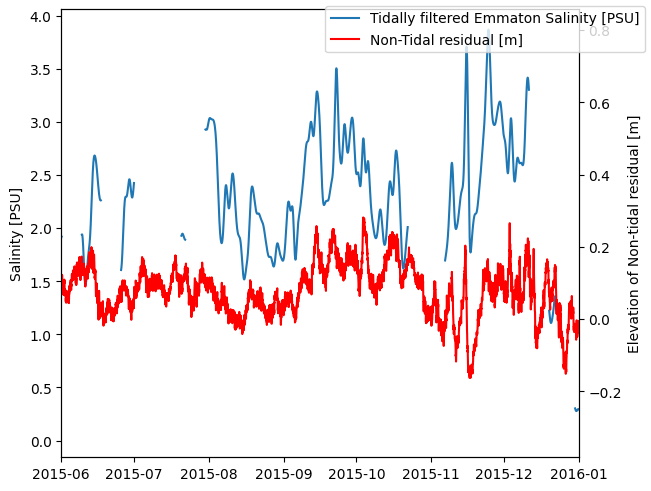

In [14]:
#plot emmaton salinity on one axis and residual on another 
fig, ax = plt.subplots(layout="constrained",sharex=True)

ax.plot(emm_filt.value, label="Tidally filtered Emmaton Salinity [PSU]")
ax.set_ylabel("Salinity [PSU]")
ax2=ax.twinx()
ax2.plot(df_pr.Residual, label="Non-Tidal residual [m]", color='r')
ax2.set_ylabel("Elevation of Non-tidal residual [m]")
fig.legend()
ax.set_xlim(datetime(2015,6,1),datetime(2016,1,1))
plt.show()

In [15]:
#read in the flux data so I can plot outflow
flux1=pd.read_csv('/global/scratch/users/jennaisrael/climate_data_processing/sl_regression/flux_from_bdschism_2025_06_05.csv',parse_dates=["datetime"],dtype=np.float32).set_index(["datetime"])#, names=['time','coyote','ccc_rock','ccc_old','swp','cvp','sjr','calaveras','east','american','sac','yolo_toedrain','yolo','northbay','napa','ccc_victoria'])
flux1




,coyote,ccc_rock,ccc_old,swp,cvp,sjr,calaveras,east,american,sac,yolo_toedrain,yolo,northbay,napa,ccc_victoria
datetime,,,,,,,,,,,,,,,
2006-10-01 00:00:00,-0.62,0.67,4.52,262.320007,120.830002,-94.860001,0.0,-25.780001,-72.769997,-330.570007,0.68,0.00,2.48,-0.01,0.0
2006-10-01 00:15:00,-0.62,0.67,4.52,263.239990,120.820000,-94.860001,0.0,-25.730000,-71.919998,-330.640015,-4.62,0.00,2.46,-0.01,0.0
2006-10-01 00:30:00,-0.62,0.66,4.52,263.410004,120.820000,-95.430000,0.0,-25.690001,-73.339996,-331.000000,-8.10,0.00,2.46,-0.01,0.0
2006-10-01 00:45:00,-0.62,0.66,4.52,263.390015,120.820000,-94.860001,0.0,-25.660000,-73.910004,-331.070007,-9.66,0.00,2.45,-0.01,0.0
2006-10-01 01:00:00,-0.62,0.66,4.52,263.350006,120.820000,-94.860001,0.0,-25.629999,-73.910004,-331.420013,-10.65,0.00,2.45,-0.01,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-13 23:00:00,-0.84,2.46,4.18,1.680000,24.850000,-179.250000,0.0,-63.320000,-116.379997,-749.340027,0.06,-0.01,1.55,-1.68,0.0
2024-05-13 23:15:00,-0.84,2.44,4.22,1.700000,24.719999,-180.100006,0.0,-63.450001,-115.820000,-749.340027,0.06,-0.01,1.55,-1.65,0.0
2024-05-13 23:30:00,-0.84,2.41,4.27,1.720000,24.570000,-179.529999,0.0,-63.360001,-116.379997,-749.340027,0.06,-0.01,1.55,-1.65,0.0


In [16]:
# pd.read_csv('/global/scratch/users/jennaisrael/climate_data_processing/sl_regression/flux.csv',header=0)

In [ ]:
# #start date for the run this file came from is 08/04/2013
# # Add in the number of seconds elapsed @ our chosen timestep
# timedelta = [pd.Timedelta(i, unit = 's') for i in flux1.time]
# timestamp = [pd.to_datetime("08-04-2013 00:00") + i for i in timedelta]
    
# flux1["time"] = timestamp

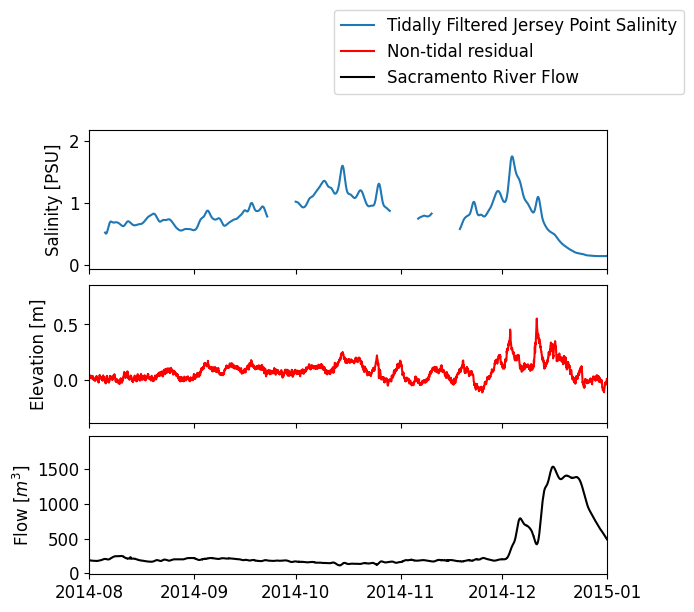

In [18]:
#plot stacked plots for jersey point salinity, on one axis and residual on another 
fig, ax = plt.subplots(3,layout="constrained",sharex=True)
mpl.rcParams.update({'font.size': 12})

ax[0].plot(jer_filt.value, label="Tidally Filtered Jersey Point Salinity")
#ax[1].plot(hro_filt.value, label="Tidally filtered Banks Pumping Plant Salinity [PSU]")
ax[0].set_ylabel("Salinity [PSU]")
#ax[1].set_ylabel("Salinity [PSU]")

ax[1].plot(df_pr.Residual, label="Non-tidal residual", color='r')
ax[1].set_ylabel("Elevation [m]")

ax[2].plot(flux1.sac*-1, label="Sacramento River Flow", color='k')
ax[2].set_ylabel("Flow [$m^3$]")

#fig.legend(loc='outside')
fig.legend(loc='lower left', bbox_to_anchor=(0.5, 1.05))#,
         # ncol=3, fancybox=True, #shadow=True)
ax[0].set_xlim(datetime(2014,8,1),datetime(2015,1,1))
plt.show()
fig.savefig('Fall_2014_stacked_plot_legend.png',dpi=400,bbox_inches='tight')

In [19]:
split=pd.DataFrame(emm_filt['my_column'].to_list(), columns = ['datetime', 'salinity'])


TypeError: list indices must be integers or slices, not str